**Data collection and analysis of bioactivity data from the ChEMBL database**

Inspired by: youtube.com/c/DataProfessor

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import Descriptors

**See available data entities**

In [2]:
available_resources = [resource for resource in dir(new_client) if not resource.startswith("_")]
print(available_resources)

['activity', 'activity_supplementary_data_by_activity', 'assay', 'assay_class', 'atc_class', 'binding_site', 'biotherapeutic', 'cell_line', 'chembl_id_lookup', 'compound_record', 'compound_structural_alert', 'description', 'document', 'document_similarity', 'drug', 'drug_indication', 'drug_warning', 'go_slim', 'image', 'mechanism', 'metabolism', 'molecule', 'molecule_form', 'official', 'organism', 'protein_class', 'similarity', 'source', 'substructure', 'target', 'target_component', 'target_relation', 'tissue', 'xref_source']


In [3]:
# Target search for hERG
target = new_client.target
target_query = target.search("herg")
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'Q12809', 'xref_name': None, 'xre...",Homo sapiens,HERG,19.0,False,CHEMBL240,"[{'accession': 'Q12809', 'component_descriptio...",SINGLE PROTEIN,9606
1,[],Homo sapiens,Melanin-concentrating hormone receptor 2/HERG,11.0,False,CHEMBL4106188,"[{'accession': 'Q12809', 'component_descriptio...",SELECTIVITY GROUP,9606
2,[],Homo sapiens,Voltage-gated potassium channel,2.0,False,CHEMBL2362996,"[{'accession': 'P51787', 'component_descriptio...",PROTEIN FAMILY,9606


**Retrieve bioactivity data (IC50) for hERG that are reported as pChEMBL values**

In [4]:
selected_target = targets["target_chembl_id"][0]
print("Selected target is:", selected_target)

activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
compounds_n=2500
df = pd.DataFrame.from_dict(res[:compounds_n])

# drop compounds missing value for the standard_value and canonical_smiles columns
df.dropna(subset=["standard_value", "canonical_smiles"], inplace=True)

# drop duplicates
df.drop_duplicates(subset=["canonical_smiles"], inplace=True)

df.head(3)

Selected target is: CHEMBL240


,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,305156,[],CHEMBL841079,Inhibition of hERG currents Kv11.1,T,None,None,BAO_0000190,BAO_0000019,...,Homo sapiens,HERG,9606,None,None,IC50,nM,UO_0000065,None,14.0
2,None,305244,[],CHEMBL691014,K+ channel blocking activity in human embryoni...,F,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,HERG,9606,None,None,IC50,nM,UO_0000065,None,32.2
3,None,305245,[],CHEMBL691013,K+ channel blocking activity in human embryoni...,F,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,HERG,9606,None,None,IC50,nM,UO_0000065,None,5950.0


**Select a subset of the dataframe**

In [5]:
selection = ["standard_value", "canonical_smiles", "molecule_chembl_id"]
df_ = df.copy()[selection]

# convert standard value to float
df_["standard_value"] = df_["standard_value"].astype(np.float64)

df_.head(3)

,standard_value,canonical_smiles,molecule_chembl_id
0,14.0,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,CHEMBL12713
2,32.2,O=C(CCCN1CC=C(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F...,CHEMBL1108
3,5950.0,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...,CHEMBL2368925


Labeling compounds as either being active, inactive or intermediate

The bioactivity data is in the IC50 unit. Compounds having values of less than 1000 nM will be considered to be active while those greater than 10,000 nM will be considered to be inactive. As for those values in between 1,000 and 10,000 nM will be referred to as intermediate.

In [6]:
conditions = [
      df_["standard_value"] < 1000,
      (df_["standard_value"] >= 1000) & (df_["standard_value"] < 10000),
      df_["standard_value"] >= 10000
      ]
values = ["Active", "Intermediate", "Inactive"]

df_["Activity class"] = np.select(conditions, values)
df_[["molecule_chembl_id", "standard_value", "Activity class"]].head()

,molecule_chembl_id,standard_value,Activity class
0,CHEMBL12713,14.0,Active
2,CHEMBL1108,32.2,Active
3,CHEMBL2368925,5950.0,Intermediate
4,CHEMBL6966,143.0,Active
5,CHEMBL1107,196.0,Active


**Calculate Lipinski descriptors**

Lipinski descriptors are a set of rule-of-thumb for evaluating the druglikeness of compounds based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile.

The Lipinski's Rule (or Rule-of-Five) stated the following:

- Molecular weight < 500 Dalton
- Octanol-water partition coefficient (LogP) < 5
- Hydrogen bond donors < 5
- Hydrogen bond acceptors < 10

Note: all numbers are multiples of 5

In [7]:
# getting molecules
mols = df_["canonical_smiles"].apply(Chem.MolFromSmiles)
# calculate descriptors
df_["Molecular weight"] = mols.apply(Descriptors.MolWt)
df_["logP"] = mols.apply(Descriptors.MolLogP)
df_["H donors"] = mols.apply(Descriptors.NumHDonors)
df_["H acceptors"] = mols.apply(Descriptors.NumHAcceptors)
df_[["molecule_chembl_id", "Molecular weight","logP", "H donors", "H acceptors"]].head(3)

,molecule_chembl_id,Molecular weight,logP,H donors,H acceptors
0,CHEMBL12713,440.950,4.6276,1,3
2,CHEMBL1108,379.435,3.6784,1,4
3,CHEMBL2368925,324.380,2.5190,1,4


**Convert IC50 to pIC50**

In [8]:
def topIC50(x):
      to_molar = x*(10**-9)
      return -np.log10(to_molar)

In [9]:
df_["pIC50"] = df_["standard_value"].apply(topIC50)
df_[["molecule_chembl_id", "pIC50"]].head(3)

,molecule_chembl_id,pIC50
0,CHEMBL12713,7.853872
2,CHEMBL1108,7.492144
3,CHEMBL2368925,5.225483


**Chemical space analysis**

Frequency plot of the active/inactive bioactivity classes

In [92]:
activity_colors = ["orange", "crimson", "royalblue"]

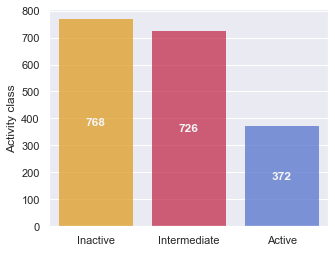

In [108]:
plt.figure(figsize = (5,4))
ax = sns.barplot(x=["Inactive", "Intermediate", "Active"],
                 y=df_["Activity class"].value_counts(),
                 palette=activity_colors,
                 linewidth=0,
                 alpha=0.75)
ax.bar_label(ax.containers[0], label_type="center", color="whitesmoke", fontweight="bold")
plt.show()

**Molecular weight versus LogP**

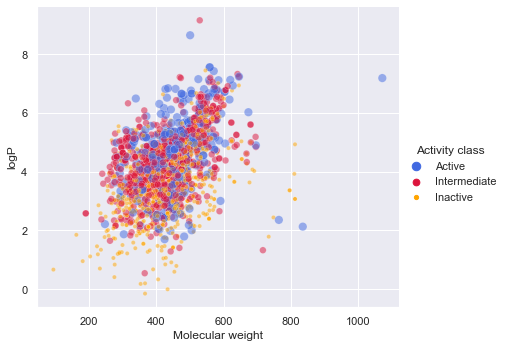

In [105]:
sns.relplot(x="Molecular weight", y="logP", 
            hue="Activity class",
            size="Activity class",
            data=df_,
            palette=activity_colors[::-1],
            alpha=0.50,
            aspect=14/12)
plt.show()